In [1]:
!pip install river


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 58.7 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.


In [2]:
!pip install dataframe-image



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 56.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 385.7/385.7 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 MB 17.7 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
import pandas as pd

path = "/content/drive/MyDrive/telecom_clean.csv"
df = pd.read_csv(path)

df.head()


,cell_id,date,time_interval,sms_in,sms_out,call_in,call_out,internet,datetime,date_str,hour
0,1,1383260400000,39,-0.449763,-0.442610,-0.464603,-0.484394,-0.479776,2013-10-31 23:00:00,2013-10-31,23
1,1,1383261000000,39,-0.434605,-0.447903,-0.461337,-0.475657,-0.479294,2013-10-31 23:10:00,2013-10-31,23
2,1,1383261600000,39,-0.428813,-0.440576,-0.467743,-0.484144,-0.480678,2013-10-31 23:20:00,2013-10-31,23
3,1,1383262200000,39,-0.389884,-0.433417,-0.480282,-0.484269,-0.495771,2013-10-31 23:30:00,2013-10-31,23
4,1,1383262800000,39,-0.438498,-0.437426,-0.477215,-0.481337,-0.499843,2013-10-31 23:40:00,2013-10-31,23


In [3]:
df.columns

Index(['cell_id', 'date', 'time_interval', 'sms_in', 'sms_out', 'call_in',
       'call_out', 'internet', 'datetime', 'date_str', 'hour'],
      dtype='object')

In [5]:
df = df.astype({
    "cell_id": "int32",
    "time_interval": "int16",
    "sms_in": "float32",
    "sms_out": "float32",
    "call_in": "float32",
    "call_out": "float32",
    "internet": "float32"
})


In [6]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from river.drift import ADWIN
import requests
pd.options.mode.copy_on_write = True

## Integrate External Features (Weather + Holidays + Events)

In [7]:
cell_usage = df.groupby("cell_id")["internet"].sum().sort_values(ascending=False)
top_cells = cell_usage.head(500).index.tolist()

df = df[df["cell_id"].isin(top_cells)].copy()
df["cell_id"] = df["cell_id"].astype("category").cat.codes

num_cells = df["cell_id"].nunique()
num_cells


500

In [8]:
import requests
import pandas as pd

def fetch_weather_openmeteo():
    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": 45.4642,      # Milan
        "longitude": 9.1900,
        "start_date": "2013-11-01",
        "end_date": "2013-12-31",
        "daily": "temperature_2m_max,temperature_2m_min,temperature_2m_mean,precipitation_sum,windspeed_10m_max",
        "timezone": "Europe/Rome"
    }
    r = requests.get(url, params=params).json()
    df = pd.DataFrame({
        "date_str": r["daily"]["time"],
        "max_temp": r["daily"]["temperature_2m_max"],
        "min_temp": r["daily"]["temperature_2m_min"],
        "temp_mean": r["daily"]["temperature_2m_mean"],
        "rainfall": r["daily"]["precipitation_sum"],
        "wind_speed": r["daily"]["windspeed_10m_max"]
    })
    return df

weather = fetch_weather_openmeteo()
weather.head()


,date_str,max_temp,min_temp,temp_mean,rainfall,wind_speed
0,2013-11-01,16.0,10.0,12.6,0.0,5.6
1,2013-11-02,14.2,11.7,12.9,1.8,7.4
2,2013-11-03,16.1,9.8,12.8,6.2,10.3
3,2013-11-04,12.4,8.4,10.4,3.6,10.8
4,2013-11-05,16.2,6.6,11.0,0.0,11.5


In [9]:
weather_map = weather.set_index("date_str").to_dict("index")


In [10]:
hol = requests.get("https://date.nager.at/api/v3/PublicHolidays/2013/IT").json()
hol = pd.DataFrame(hol)
hol["date_str"] = pd.to_datetime(hol["date"]).dt.strftime("%Y-%m-%d")
hol_map = hol.set_index("date_str")["localName"].to_dict()

# convert to flag
holiday_flag_map = {k: 1 for k in hol_map}


In [11]:
dates = df["date_str"].unique()
event_count_map = {d: 0 for d in dates}
event_importance_map = {d: 0 for d in dates}


## ADD EXTERNAL FEATURES USING .map() (NO RAM SPIKE)

In [12]:
df["temp_mean"] = df["date_str"].map(lambda x: weather_map.get(x, {}).get("temp_mean", 0))
df["max_temp"] = df["date_str"].map(lambda x: weather_map.get(x, {}).get("max_temp", 0))
df["min_temp"] = df["date_str"].map(lambda x: weather_map.get(x, {}).get("min_temp", 0))
df["rainfall"] = df["date_str"].map(lambda x: weather_map.get(x, {}).get("rainfall", 0))
df["wind_speed"] = df["date_str"].map(lambda x: weather_map.get(x, {}).get("wind_speed", 0))

df["holiday_flag"] = df["date_str"].map(lambda x: holiday_flag_map.get(x, 0))
df["event_count"] = df["date_str"].map(lambda x: event_count_map.get(x, 0))
df["event_importance"] = df["date_str"].map(lambda x: event_importance_map.get(x, 0))


In [13]:
FEATURES = [
    "sms_in","sms_out","call_in","call_out","internet",
    "temp_mean","max_temp","min_temp","rainfall","wind_speed",
    "holiday_flag","event_count","event_importance"
]

df = df.sort_values(["datetime","time_interval","cell_id"])
grouped = df.groupby(["datetime","time_interval"])

X_list, Y_list = [], []

for (_, _), g in grouped:
    x = np.zeros((num_cells, len(FEATURES)), dtype=np.float32)
    y = np.zeros((num_cells, 5), dtype=np.float32)
    for _, row in g.iterrows():
        cid = int(row["cell_id"])
        x[cid] = row[FEATURES].values
        y[cid] = row[["sms_in","sms_out","call_in","call_out","internet"]].values
    X_list.append(x)
    Y_list.append(y)

X = torch.tensor(np.stack(X_list))
Y = torch.tensor(np.stack(Y_list))


In [14]:
T = X.size(0)
print("Tensor Shapes:", X.shape, Y.shape, "T =", T)

Tensor Shapes: torch.Size([6660, 500, 13]) torch.Size([6660, 500, 5]) T = 6660


## BASELINE 1 — LSTM

In [15]:
import torch.optim as optim
from tqdm import tqdm

In [16]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 5)
    def forward(self, seq):
        _, (h, _) = self.lstm(seq)
        return self.fc(h[-1])

seq = X.mean(1)
target = Y.mean(1)

lag = 24
Xs, Ys = [], []

for t in range(lag, T):
    Xs.append(seq[t-lag:t])
    Ys.append(target[t])

Xs = torch.stack(Xs)
Ys = torch.stack(Ys)

model_lstm = LSTMModel(seq.shape[1])
opt = optim.Adam(model_lstm.parameters(), lr=0.001)
crit = nn.MSELoss()

EPOCHS = 25
for e in range(EPOCHS):
    pred = model_lstm(Xs)
    loss = crit(pred, Ys)
    opt.zero_grad()
    loss.backward()
    opt.step()

pred_lstm = model_lstm(Xs[-1].unsqueeze(0)).detach().numpy()
true_lstm = Ys[-1].numpy()


## BASELINE 2 — FedAvg

In [17]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from copy import deepcopy

class SimpleNet(nn.Module):
    def __init__(self, in_dim, out_dim=5):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, out_dim)
    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))

def run_fedavg(X_train, y_train, X_test, y_test,
               num_clients=5, rounds=5, epochs=25, lr=0.01):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    in_dim = X_train.shape[1]
    out_dim = y_train.shape[1]

    global_model = SimpleNet(in_dim, out_dim).to(device)
    client_models = [SimpleNet(in_dim, out_dim).to(device) for _ in range(num_clients)]

    total = len(X_train)
    split_size = total // num_clients

    client_data = []
    for i in range(num_clients):
        s = i * split_size
        e = (i+1) * split_size if i < num_clients-1 else total

        xi = torch.tensor(X_train.values[s:e], dtype=torch.float32).to(device)
        yi = torch.tensor(y_train.values[s:e], dtype=torch.float32).to(device)

        client_data.append((xi, yi))

    for _ in range(rounds):
        global_w = deepcopy(global_model.state_dict())
        for cm in client_models:
            cm.load_state_dict(global_w)

        for cm, (xi, yi) in zip(client_models, client_data):
            opt = optim.SGD(cm.parameters(), lr=lr)
            loss_fn = nn.MSELoss()

            for _ in range(epochs):
                opt.zero_grad()
                pred = cm(xi)
                loss = loss_fn(pred, yi)
                loss.backward()
                opt.step()

        new_w = deepcopy(global_w)
        for k in new_w:
            new_w[k] = torch.mean(torch.stack([cm.state_dict()[k] for cm in client_models]), dim=0)

        global_model.load_state_dict(new_w)

    X_t = torch.tensor(X_test.values, dtype=torch.float32).to(device)
    with torch.no_grad():
        y_pred = global_model(X_t).cpu().numpy()

    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    return mse, mae, y_pred

# Prepare data for FedAvg
Xf = seq[:-1].numpy()
Yf = target[1:].numpy()
Xf = pd.DataFrame(Xf)
Yf = pd.DataFrame(Yf)

cut = int(0.8*len(Xf))
mse_fed, mae_fed, pred_fed = run_fedavg(Xf[:cut], Yf[:cut], Xf[cut:], Yf[cut:])


## BASELINE 3 - SplitNN

In [18]:
class ClientNet(nn.Module):
    def __init__(self, in_dim, embed_dim=32):
        super().__init__()
        self.fc = nn.Linear(in_dim, embed_dim)
        self.relu = nn.ReLU()
    def forward(self, x):
        return self.relu(self.fc(x))

class ServerNet(nn.Module):
    def __init__(self, embed_total, out_dim=5):
        super().__init__()
        self.fc2 = nn.Linear(embed_total, 64)
        self.relu = nn.ReLU()
        self.fc3 = nn.Linear(64, out_dim)
    def forward(self, x):
        return self.fc3(self.relu(self.fc2(x)))

def run_splitnn(train_df, test_df, epochs=20, lr=0.01):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    comp1 = train_df[['sms_in','sms_out']].values
    comp2 = train_df[['call_in','call_out','internet']].values
    labels = train_df[["sms_in","sms_out","call_in","call_out","internet"]].values

    c1 = ClientNet(2,32).to(device)
    c2 = ClientNet(3,32).to(device)
    server = ServerNet(32*2, 5).to(device)

    opt = optim.SGD(list(c1.parameters()) + list(c2.parameters()) + list(server.parameters()), lr=lr)
    loss_fn = nn.MSELoss()

    for _ in range(epochs):
        opt.zero_grad()
        z1 = c1(torch.tensor(comp1, dtype=torch.float32).to(device))
        z2 = c2(torch.tensor(comp2, dtype=torch.float32).to(device))
        z = torch.cat([z1, z2], dim=1)
        pred = server(z)
        loss = loss_fn(pred, torch.tensor(labels, dtype=torch.float32).to(device))
        loss.backward()
        opt.step()

    comp1_te = test_df[['sms_in','sms_out']].values
    comp2_te = test_df[['call_in','call_out','internet']].values
    labels_te = test_df[["sms_in","sms_out","call_in","call_out","internet"]].values

    with torch.no_grad():
        z1 = c1(torch.tensor(comp1_te, dtype=torch.float32).to(device))
        z2 = c2(torch.tensor(comp2_te, dtype=torch.float32).to(device))
        z = torch.cat([z1, z2], dim=1)
        pred = server(z).cpu().numpy()

    mse = mean_squared_error(labels_te, pred)
    mae = mean_absolute_error(labels_te, pred)
    return mse, mae, pred

# Prepare data
split_cut = int(0.8*len(df))
train_df_split = df.iloc[:split_cut]
test_df_split  = df.iloc[split_cut:]

mse_vfl, mae_vfl, pred_vfl = run_splitnn(train_df_split, test_df_split)


## Adaptive ST-VFL
### ST-GCN + VFL + Adaptive FL

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from river.drift import ADWIN

device = "cuda" if torch.cuda.is_available() else "cpu"

class GATLayer(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.fc = nn.Linear(in_dim, out_dim, bias=False)
        self.att = nn.Parameter(torch.randn(out_dim, 1))  # small attention vector
        self.leakyrelu = nn.LeakyReLU(0.2)

    def forward(self, X, A):
        H = self.fc(X)                         # (C, F_out)
        scores = (H @ self.att).squeeze(-1)    # (C,)
        scores = scores.unsqueeze(0) + scores.unsqueeze(1)  # pairwise
        scores = self.leakyrelu(scores)

        mask = (A > 0).float()
        scores = scores.masked_fill(mask == 0, -1e9)
        attn = torch.softmax(scores, dim=1)

        return attn @ H                        # weighted aggregation


# ENCODERS (VFL SPLIT)
class Encoder(nn.Module):
    def __init__(self, in_dim, out_dim=16):
        super().__init__()
        self.fc = nn.Linear(in_dim, out_dim)
        self.ln = nn.LayerNorm(out_dim)

    def forward(self, x):
        return torch.relu(self.ln(self.fc(x)))


# TEMPORAL BLOCK (Conv)
class TemporalConv(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.conv = nn.Conv1d(in_dim, out_dim, kernel_size=3, padding=1)
        self.ln = nn.LayerNorm(out_dim)

    def forward(self, X):
        # input X: (T, C, F)
        X = X.permute(1, 2, 0)       # (C, F, T)
        Y = torch.relu(self.conv(X)) # (C, out_dim, T)
        Y = Y.permute(2, 0, 1)       # (T, C, out_dim)
        return self.ln(Y)

class OptimizedSTVFL(nn.Module):
    def __init__(self, num_cells):
        super().__init__()

        self.enc1 = Encoder(2, 16)
        self.enc2 = Encoder(2, 16)
        self.enc3 = Encoder(1, 16)

        self.temporal = TemporalConv(48, 32)
        self.gat = GATLayer(32, 16)                    # graph attention
        self.gru = nn.GRU(16 * num_cells, 64, batch_first=True)
        self.fc = nn.Linear(64, 5)

    def forward(self, X, A):
        p1 = self.enc1(X[..., p1_idx])
        p2 = self.enc2(X[..., p2_idx])
        p3 = self.enc3(X[..., p3_idx])
        Z = torch.cat([p1, p2, p3], dim=-1)   # (T, C, 48)

        Z = self.temporal(Z)                 # (T, C, 32)

        # Vectorized graph attention
        Z2 = torch.stack([self.gat(Z[t], A) for t in range(Z.size(0))])
        G = Z2.reshape(Z2.size(0), -1).unsqueeze(0)

        out, _ = self.gru(G)
        return self.fc(out[:, -1])

# training loop
model = OptimizedSTVFL(num_cells).to(device)
opt = optim.Adam(model.parameters(), lr=1e-3)
crit = nn.MSELoss()
drift = ADWIN()

EPOCHS = 15
WINDOW = 24
TARGET_CELL = 15
LR_MIN, LR_MAX = 5e-5, 5e-3

for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}")

    for t in range(WINDOW, T):
        Xt = X[t-WINDOW:t].to(device)
        y_true = Y[t, TARGET_CELL].unsqueeze(0).to(device)

        pred = model(Xt, A)
        loss = crit(pred, y_true)

        opt.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt.step()

        drift.update(float(loss.item()))
        if drift.drift_detected:
            opt.param_groups[0]["lr"] = min(LR_MAX, opt.param_groups[0]["lr"] * 1.05)
        else:
            opt.param_groups[0]["lr"] = max(LR_MIN, opt.param_groups[0]["lr"] * 0.995)

print("Training Completed.")

pred_stgcn = model(X[-WINDOW:].to(device), A).detach().cpu().numpy()
true_stgcn = Y[-1][TARGET_CELL].cpu().numpy()


Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Training Completed.


In [25]:
comparison = pd.DataFrame({
    "Model": ["LSTM", "FedAvg", "VFL SplitNN", "Adaptive ST-VFL"],
    "MSE": [
        ((pred_lstm - true_lstm)**2).mean(),
        mse_fed,
        mse_vfl,
        ((pred_stgcn - true_stgcn)**2).mean()
    ],
    "MAE": [
        abs(pred_lstm - true_lstm).mean(),
        mae_fed,
        mae_vfl,
        abs(pred_stgcn - true_stgcn).mean()
    ]
})

comparison


,Model,MSE,MAE
0,LSTM,0.386262,0.524459
1,FedAvg,2.819680,1.112391
2,VFL SplitNN,1.026500,0.715511
3,Adaptive ST-VFL,0.023998,0.142565


In [26]:
def safe_float(x):
    return float(np.array(x).astype(float))

comparison = pd.DataFrame({
    "Model": ["LSTM", "FedAvg", "VFL SplitNN", "Adaptive ST-VFL"],
    "MSE": [
        safe_float(((pred_lstm - true_lstm)**2).mean()),
        safe_float(mse_fed),
        safe_float(mse_vfl),
        safe_float(((pred_stgcn - true_stgcn)**2).mean())
    ],
    "MAE": [
        safe_float(abs(pred_lstm - true_lstm).mean()),
        safe_float(mae_fed),
        safe_float(mae_vfl),
        safe_float(abs(pred_stgcn - true_stgcn).mean())
    ]
})

comparison["MSE"] = pd.to_numeric(comparison["MSE"], errors="coerce")
comparison["MAE"] = pd.to_numeric(comparison["MAE"], errors="coerce")

comparison = comparison.fillna(0.0)

styled = (
    comparison.style
        .set_caption("Model Performance Comparison")
        .format("{:.6f}", subset=["MSE", "MAE"])
        .background_gradient(cmap="Blues", subset=["MSE", "MAE"])
        .set_properties(**{
            "text-align": "center",
            "font-size": "14px",
            "border": "1px solid black"
        })
        .hide(axis="index")
)

import dataframe_image as dfi
dfi.export(styled, "comparison_table.png", table_conversion="matplotlib")

print("Saved: comparison_table.png")


Saved: comparison_table.png


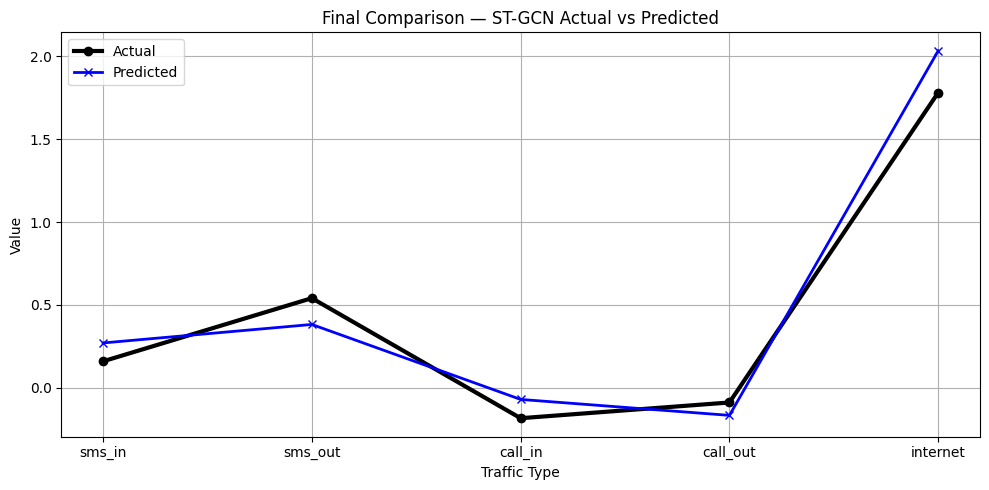

Saved stgcn_vector_plot.png


In [27]:
import matplotlib.pyplot as plt
import numpy as np

features = ["sms_in", "sms_out", "call_in", "call_out", "internet"]

# Ensure arrays are flat (1D, length 5)
true_vec = np.array(true_stgcn).reshape(-1)
pred_vec = np.array(pred_stgcn).reshape(-1)

plt.figure(figsize=(10,5))
plt.plot(features, true_vec, marker='o', label="Actual", linewidth=3, color='black')
plt.plot(features, pred_vec, marker='x', label="Predicted", linewidth=2, color='blue')

plt.title("Final Comparison — ST-GCN Actual vs Predicted")
plt.xlabel("Traffic Type")
plt.ylabel("Value")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("stgcn_vector_plot.png", dpi=300)
plt.show()

print("Saved stgcn_vector_plot.png")


In [28]:
def safe_float(x):
    return float(np.array(x).astype(float))

comparison = pd.DataFrame({
    "Model": ["LSTM", "FedAvg", "VFL SplitNN", "Adaptive ST-VFL"],
    "MSE": [
        safe_float(((pred_lstm - true_lstm)**2).mean()),
        safe_float(mse_fed),
        safe_float(mse_vfl),
        safe_float(((pred_stgcn - true_stgcn)**2).mean())
    ],
    "MAE": [
        safe_float(abs(pred_lstm - true_lstm).mean()),
        safe_float(mae_fed),
        safe_float(mae_vfl),
        safe_float(abs(pred_stgcn - true_stgcn).mean())
    ]
})

comparison["MSE"] = pd.to_numeric(comparison["MSE"], errors="coerce")
comparison["MAE"] = pd.to_numeric(comparison["MAE"], errors="coerce")
comparison = comparison.fillna(0.0)

styled = (
    comparison.style
        .set_caption("Model Performance Comparison")
        .format("{:.6f}", subset=["MSE", "MAE"])
        .set_table_styles([
            {"selector": "caption", "props": [("font-size", "16px"), ("font-weight", "bold")]},
            {"selector": "th", "props": [("font-size", "14px"), ("font-weight", "bold"),
                                         ("border", "1px solid black"), ("text-align", "center")]},
            {"selector": "td", "props": [("font-size", "13px"),
                                         ("border", "1px solid #444"),
                                         ("text-align", "center")]}
        ])
        .hide(axis="index")
)

import dataframe_image as dfi
dfi.export(styled, "comparison_table.png", table_conversion="matplotlib")

print("Saved: comparison_table2.png")


Saved: comparison_table2.png
